# Sampling Measure Zero Polyhedra

We start with a HPolyhedron defined by
$$
    Ax \leq b
$$
$$
    Cx = d
$$

## Defining the original polyhedron P

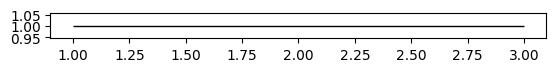

In [1]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np
import matplotlib.pyplot as plt

P_verts = np.array([[1,1],[3,1]])
P = Polyhedron.from_vertices(P_verts)
P._vertices = P_verts
P.plot()

In [2]:
P.set.A()

array([[ 1., -0.],
       [-1.,  0.],
       [ 0.,  1.],
       [-0., -1.]])

In [3]:
P.set.b()

array([ 3., -1.,  1., -1.])

In [4]:
P.has_equality_constraints()

True

In [5]:
A,b,C,d = P.get_separated_inequality_equality_constraints()

In [6]:
A

array([[ 1., -0.],
       [-1.,  0.]])

In [7]:
b

array([ 3., -1.])

In [8]:
C

array([[0., 1.]])

In [9]:
d

array([1.])

## Finding the null space of a matrix

In [10]:
import numpy as np
from scipy.linalg import null_space

# Define your matrix X
X = np.array([
    [1, 2, 3, 5],
    [4, 5, 6, 2],
    [7, 8, 9, 1]
])

# Find the basis for the kernel of X
kernel_basis = null_space(X)

print("Basis for the kernel of X:")
print(kernel_basis)
X @ kernel_basis


Basis for the kernel of X:
[[-4.08248290e-01]
 [ 8.16496581e-01]
 [-4.08248290e-01]
 [-4.99600361e-16]]


array([[-8.8817842e-16],
       [ 0.0000000e+00],
       [-8.8817842e-16]])

### Find the basis of the null space of C

In [11]:
V = null_space(C)
V

array([[-1.],
       [ 0.]])

In [12]:
V.shape

(2, 1)

## Find $x_0$ such that $Cx_0 = d$

In [13]:
# Compute the pseudo-inverse of C
C_pinv = np.linalg.pinv(C)

# Use the pseudo-inverse to find x_0
x_0 = np.dot(C_pinv, d)
x_0

array([0., 1.])

In [14]:
# Alternatively, solve the system Cx = d in a least squares sense
x_0 = np.linalg.lstsq(C, d, rcond=None)[0]
x_0

array([0., 1.])

In [15]:
Q = Polyhedron(A = A@V, b = b - A @ x_0)

In [16]:
q_samples = Q.get_samples(20)
q_samples.shape

(20, 1)

In [17]:
V.shape

(2, 1)

In [18]:
p_samples = q_samples @ V.T + x_0
p_samples

array([[1.63728092, 1.        ],
       [1.38725268, 1.        ],
       [2.78249698, 1.        ],
       [1.74587215, 1.        ],
       [1.47972397, 1.        ],
       [2.96997235, 1.        ],
       [1.00951711, 1.        ],
       [1.05989411, 1.        ],
       [1.9887229 , 1.        ],
       [1.80140855, 1.        ],
       [1.57284154, 1.        ],
       [2.61160661, 1.        ],
       [2.19317159, 1.        ],
       [2.98084942, 1.        ],
       [2.5838568 , 1.        ],
       [2.38993794, 1.        ],
       [2.2299118 , 1.        ],
       [1.15979387, 1.        ],
       [2.76887394, 1.        ],
       [1.10192532, 1.        ]])

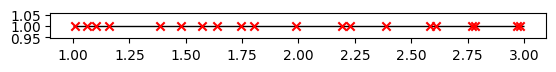

In [19]:
P.plot()
plt.scatter(p_samples[:,0], p_samples[:,1], c = 'r', marker='x')

Now that we've built in this functionality into the `Polyhedron` class, can simply call `get_samples`

In [20]:
samples = P.get_samples(20)
len(samples)
samples

array([[1.63728092, 1.        ],
       [1.38725268, 1.        ],
       [2.78249698, 1.        ],
       [1.74587215, 1.        ],
       [1.47972397, 1.        ],
       [2.96997235, 1.        ],
       [1.00951711, 1.        ],
       [1.05989411, 1.        ],
       [1.9887229 , 1.        ],
       [1.80140855, 1.        ],
       [1.57284154, 1.        ],
       [2.61160661, 1.        ],
       [2.19317159, 1.        ],
       [2.98084942, 1.        ],
       [2.5838568 , 1.        ],
       [2.38993794, 1.        ],
       [2.2299118 , 1.        ],
       [1.15979387, 1.        ],
       [2.76887394, 1.        ],
       [1.10192532, 1.        ]])

# Check that it works for contact sets with equality constraints

100%|██████████| 52/52 [00:00<00:00, 3886.04it/s]


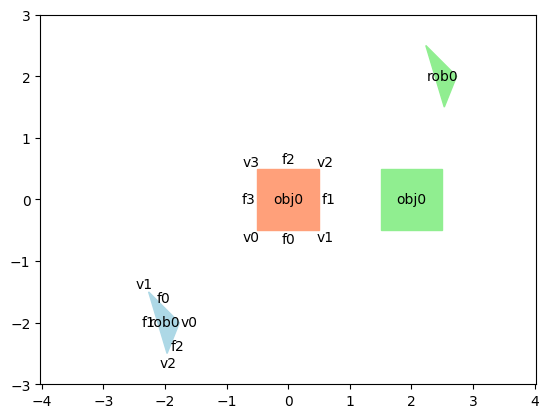

In [21]:
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams


graph_file = ContactGraphGeneratorParams.graph_file_path_from_name("cg_simple_2")
cg = ContactGraph.load_from_file(graph_file)
cg.plot()


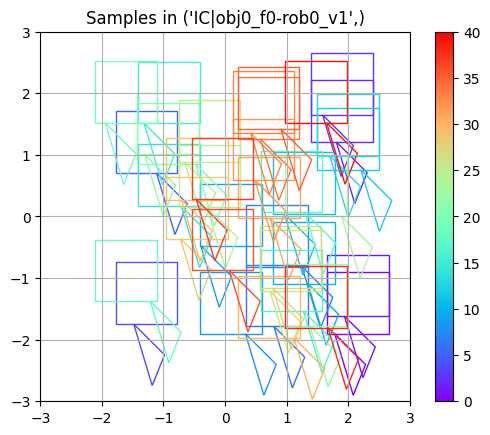

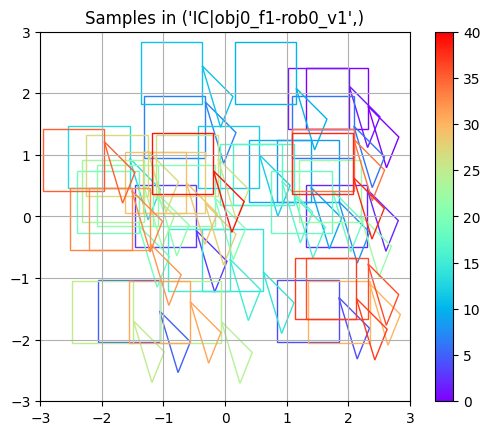

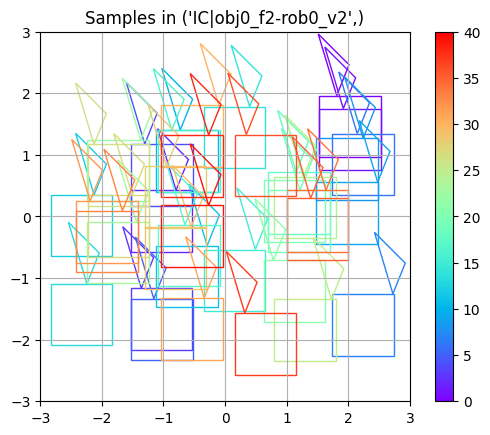

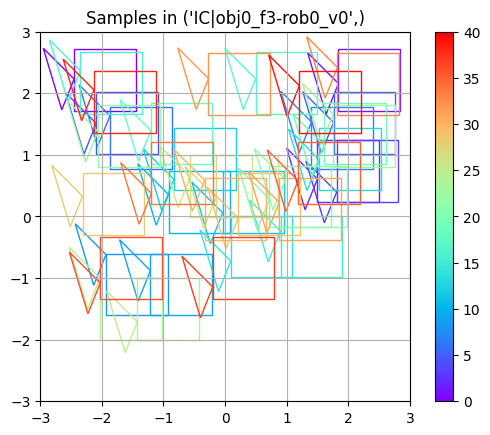

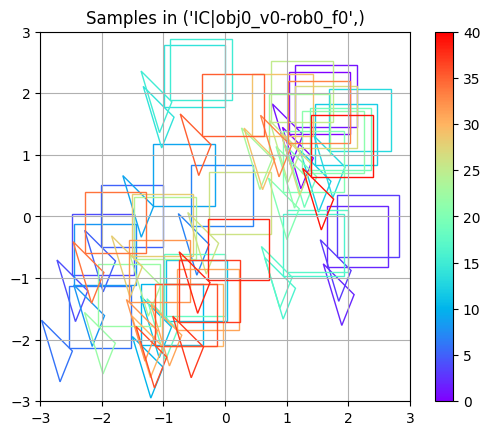

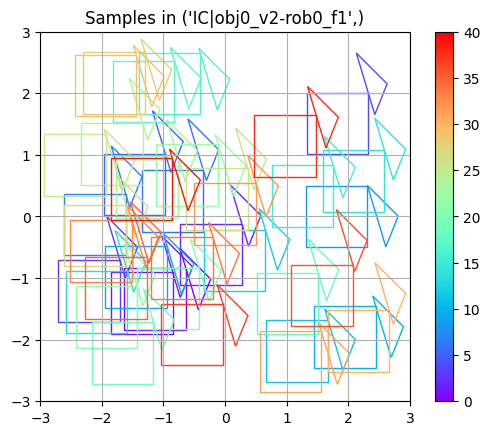

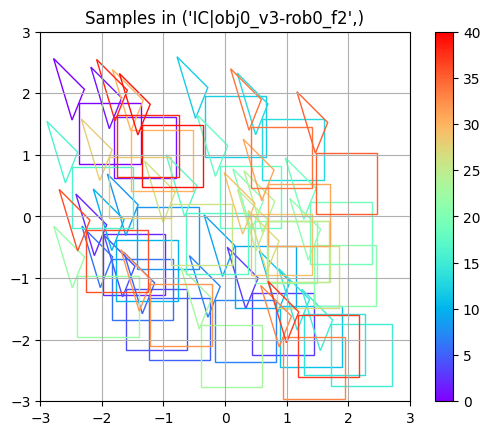

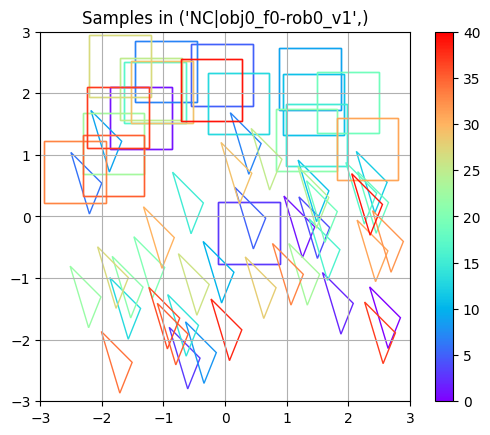

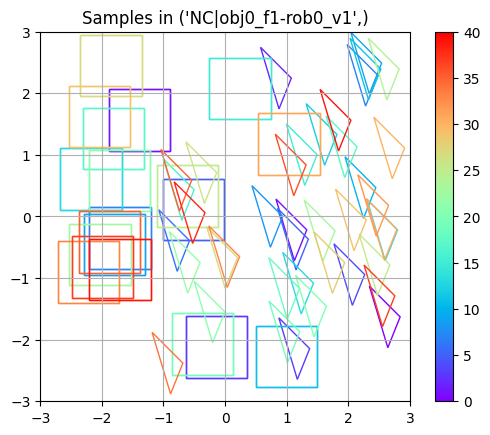

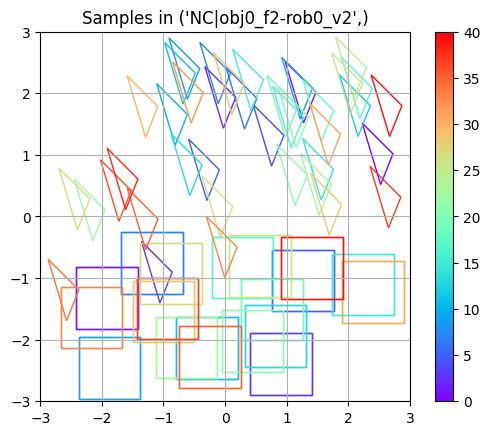

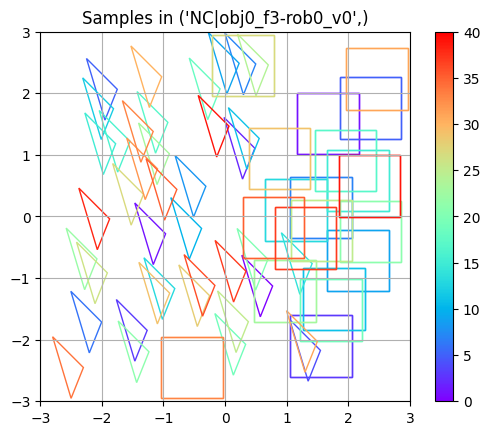

In [22]:
for v in cg.vertex_names:
    cg.plot_samples_in_set(v, 20)

# Debugging Empty Nullspace Polyhedron in cg_maze_b1

100%|██████████| 151/151 [00:00<00:00, 663.59it/s]


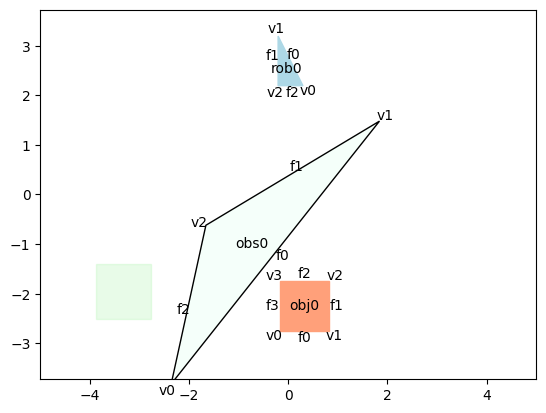

In [1]:
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph

graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_maze_b1")
cg = IncrementalContactGraph.load_from_file(graph_file)
cg.plot()

In [3]:
vertex_path = ['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_v0', 'NC|obj0_f2-rob0_f2')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_v1-rob0_f1', 'NC|obj0_f2-rob0_f2')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f2-rob0_f2')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('NC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')"]
for v in vertex_path:
    print(f"generating neighbors for {v}")
    cg.generate_neighbors(v)
cg.n_vertices


generating neighbors for source
generating neighbors for ('NC|obs0_f0-obj0_v3', 'NC|obs0_f1-rob0_v0', 'NC|obj0_f2-rob0_f2')


KeyboardInterrupt: 